In [ ]:
import networkx as nx
import ndlib.models.ModelConfig as mc
import ndlib.models.epidemics as ep
from ndlib.utils import multi_runs

import abc
from bokeh.palettes import Category20_9 as cols
import os
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
import future.utils
import six
import random

We saved all of our plots in a folder named 'assets' instead of using plt.show()

In [ ]:
filepath = '../assets'

if not os.path.exists(os.path.join(filepath, 'assets')):
    os.makedirs(os.path.join(filepath, 'assets'))
    print("'assets' folder has been created in the specified filepath.")
else:
    print("'assets' folder already exists in the specified filepath.")

Here, we override the DiffusionTrend function from Ndlib to customize the diffusion plot.

In [ ]:
__author__ = "Giulio Rossetti"
__license__ = "BSD-2-Clause"
__email__ = "giulio.rossetti@gmail.com"


@six.add_metaclass(abc.ABCMeta)
class DiffusionPlot(object):
    def __init__(self, model, trends):
        self.model = model
        self.trends = trends
        statuses = model.available_statuses
        self.srev = {v: k for k, v in future.utils.iteritems(statuses)}
        self.ylabel = ""
        self.title = ""
        self.nnodes = model.graph.number_of_nodes()
        self.normalized = True

    @abc.abstractmethod
    def iteration_series(self, percentile):
        """
        Prepare the data to be visualized

        :param percentile: The percentile for the trend variance area
        :return: a dictionary where iteration ids are keys and the associated values are the computed measures
        """
        pass

    def plot(self, filename=None, percentile=90, statuses=None, descr=None):
        """
        Generates the plot

        :param filename: Output filename
        :param percentile: The percentile for the trend variance area
        :param statuses: List of statuses to plot. If not specified all statuses trends will be shown.
        """

        pres = self.iteration_series(percentile)

        plt.figure(figsize=(20, 15))

        mx = 0
        i = 0
        for k, l in future.utils.iteritems(pres):

            if statuses is not None and self.srev[k] not in statuses:
                continue
            mx = len(l[0])
            if self.normalized:
                plt.plot(
                    range(0, mx),
                    l[1] / self.nnodes,
                    lw=2,
                    label=self.srev[k],
                    alpha=0.5,
                )  # , color=cols[i])
                plt.fill_between(
                    range(0, mx), l[0] / self.nnodes, l[2] / self.nnodes, alpha=0.2
                )
                # ,color=cols[i])
            else:
                plt.plot(
                    range(0, mx), l[1], lw=2, label=self.srev[k], alpha=0.5
                )  # , color=cols[i])
                plt.fill_between(range(0, mx), l[0], l[2], alpha=0.2)  # ,color=cols[i])

            i += 1

        plt.grid(axis="y")
        plt.xlabel("Iterations", fontsize=40)
        plt.ylabel(self.ylabel, fontsize=40)
        plt.tick_params(axis='both', which='major', labelsize=36)
        plt.legend(loc="best", fontsize=36)

        if descr is not None:
            plt.title(f"fraction infected: {descr[0]}, beta: {descr[1]}, gamma: {descr[2]}", fontsize=38) 
        plt.xlim((0, mx))

        plt.tight_layout()
        if filename is not None:
            plt.savefig(filename)
            plt.clf()
        else:
            plt.show()

class DiffusionTrend(DiffusionPlot):
    def __init__(self, model, trends):
        """
        :param model: The model object
        :param trends: The computed simulation trends
        """
        super(self.__class__, self).__init__(model, trends)
        self.ylabel = "#Nodes"
        self.title = "Diffusion Trend"

    def iteration_series(self, percentile):

        series = {k: [] for k in self.srev.keys()}

        presences = {k: [] for k in self.srev.keys()}
        for t in self.trends:

            for st in t:
                for k in t[st]["node_count"]:
                    presences[k].append(np.array(t[st]["node_count"][k]))

        for st in presences:
            tp = np.percentile(np.array(presences[st]), percentile, axis=0)
            bp = np.percentile(np.array(presences[st]), 100 - percentile, axis=0)
            av = np.average(np.array(presences[st]), axis=0)
            series[st] = (tp, av, bp)

        return series

Functions to implement SIR disease spread on the network

In [ ]:
class Graph:
    def __init__(self, num_of_nodes):
        self.num_of_nodes = num_of_nodes

    def barabasi_albert(self, num_of_edges):
        return nx.barabasi_albert_graph(self.num_of_nodes, num_of_edges)

    def watts_strogatz(self, k_nearest_neighbors, rewiring_probability):
        return nx.watts_strogatz_graph(self.num_of_nodes, k_nearest_neighbors, rewiring_probability)

    def erdos_renyi(self, edge_creation_probability):
        return nx.erdos_renyi_graph(self.num_of_nodes, edge_creation_probability)

In [ ]:
def set_config(beta, gamma, fraction_infected):
    config = mc.Configuration()
    config.add_model_parameter('beta', beta)
    config.add_model_parameter('gamma', gamma)
    config.add_model_parameter("fraction_infected", fraction_infected)
    return config

def run_simulation(beta, gamma, fraction_infected, graph, network_abbrv):        
    config = set_config(beta, gamma, fraction_infected)
    sir_model = ep.SIRModel(graph)
    sir_model.set_initial_status(config)
    trends = multi_runs(sir_model, execution_number=10, iteration_number=100, infection_sets=None, nprocesses=4)
    viz = DiffusionTrend(sir_model, trends)
    viz.plot(filename=f"../assets/{network_abbrv}_trend_beta{beta}_gamma{gamma}_infected{fraction_infected}.png", descr=[fraction_infected, beta, gamma])

Run multiple simulations across different network models

In [ ]:
# Set network model params
N = 1000
graph = Graph(num_of_nodes=N)
ba_graph = graph.barabasi_albert(num_of_edges=5)
ws_graph = graph.watts_strogatz(k_nearest_neighbors=6, rewiring_probability=0.1)
er_graph = graph.erdos_renyi(edge_creation_probability=0.1)

# Set disease params
infection_rate = 0.3
recovery_rate = 0.1
fraction = 0.01

In [ ]:
run_simulation(infection_rate, recovery_rate, fraction, ba_graph, 'BA')
run_simulation(infection_rate, recovery_rate, fraction, ws_graph, 'WS')
run_simulation(infection_rate, recovery_rate, fraction, er_graph, 'ER')

Now, we want to see how varying the number of nodes affect the average shortest path length across network types.

In [ ]:
def compute_average_shortest_path_length(N):
    graph = Graph(num_of_nodes=N)
    
    ba_graph = graph.barabasi_albert(num_of_edges=5)
    ws_graph = graph.watts_strogatz(k_nearest_neighbors=6, rewiring_probability=0.1)
    er_graph = graph.erdos_renyi(edge_creation_probability=0.1)
    
    ba_avg_len = nx.average_shortest_path_length(ba_graph)
    ws_avg_len = nx.average_shortest_path_length(ws_graph)
    er_avg_len = nx.average_shortest_path_length(er_graph)
    
    return ba_avg_len, ws_avg_len, er_avg_len

In [ ]:
N_values = [100, 1000, 10000]

ba_results = []
ws_results = []
er_results = []

for N in N_values:
    ba_len, ws_len, er_len = compute_average_shortest_path_length(N)
    ba_results.append(ba_len)
    ws_results.append(ws_len)
    er_results.append(er_len)


plt.figure(figsize=(10,6))
plt.loglog(N_values, ba_results, 'o-', label='Barabási-Albert')
plt.loglog(N_values, ws_results, 'o-', label='Watts-Strogatz')
plt.loglog(N_values, er_results, 'o-', label='Erdős–Rényi')

bar_width = 0.25
r1 = np.arange(len(N_values))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

plt.figure(figsize=(10,6))

plt.bar(r1, ba_results, color='#122640', width=bar_width, edgecolor='grey', label='Barabasi-Albert', log=True)
plt.bar(r2, ws_results, color='#558F8B', width=bar_width, edgecolor='grey', label='Watts-Strogatz', log=True)
plt.bar(r3, er_results, color='#B8D5B2', width=bar_width, edgecolor='grey', label='Erdos-Renyi', log=True)

plt.xlabel('Number of nodes', fontweight='bold', fontsize=15)
plt.xticks([r + bar_width for r in range(len(ba_results))], ['100', '1000', '10000'])
plt.ylabel('Average shortest path length', fontweight='bold', fontsize=15)
plt.yticks([2, 3, 4, 5, 6, 7, 8, 9], ['2', '3', '4', '5', '6', '7', '8', '9'])
plt.tick_params(axis='both', which='major', labelsize=20)
plt.title('Average shortest path length vs. Number of nodes', fontsize=20)
plt.legend()
plt.grid(True, which="both", ls="--", c='0.65')
plt.tight_layout()
plt.savefig('../assets/stats_avg_shortest_path_length.png')

To see network statistics, we will vary the parameter setting for each network model while keeping the number of nodes constant to 1000. To do this, we need to create the instances of Graph class.

In [ ]:
N = 1000
graph = Graph(num_of_nodes=N)
ba_num_of_edges = range(2, 11) 
ws_k_nearest_neighbors = range(4, 10)
ws_rewiring_probabilities = [0.01, 0.1, 0.5, 1.0] 
er_creation_probabilities = [0.05, 0.1, 0.5, 0.7]

In [ ]:
ba_degrees = []
ws_degrees = []
er_degrees = []

for edge in ba_num_of_edges:
    ba_graph = graph.barabasi_albert(num_of_edges=edge)
    ba_degrees.extend(list(nx.degree_centrality(ba_graph).values()))

for k in ws_k_nearest_neighbors:
    for p in ws_rewiring_probabilities :
        ws_graph = graph.watts_strogatz(k_nearest_neighbors=k, rewiring_probability=p)
        ws_degrees.extend(list(nx.degree_centrality(ws_graph).values()))

for p in er_creation_probabilities:
    er_graph = graph.erdos_renyi(edge_creation_probability=p)
    er_degrees.extend(list(nx.degree_centrality(er_graph).values()))

def plot_degree_distribution(network_abbrv):
    if network_abbrv == 'ba':
        title = 'Barabási-Albert Degree Distributions'
        degrees = ba_degrees
    elif network_abbrv == 'er':
        title = 'Erdős–Rényi Degree Distributions'
        degrees = er_degrees
    elif network_abbrv == 'ws':
        title = 'Watts-Strogatz Degree Distributions'
        degrees = ws_degrees

    plt.figure(figsize=(15, 12))
    plt.hist(degrees, bins=30, color='skyblue', edgecolor='black')
    plt.xlabel('Degree Centrality', fontsize=32)
    plt.xticks(fontsize=24) 
    plt.ylabel('Frequency', fontsize=32)
    plt.yticks(fontsize=24) 
    plt.savefig(f'../assets/{network_abbrv}_degree_centrality_distribution.png')
    plt.close()

In [ ]:
plot_degree_distribution('ba')
plot_degree_distribution('ws')
plot_degree_distribution('er')

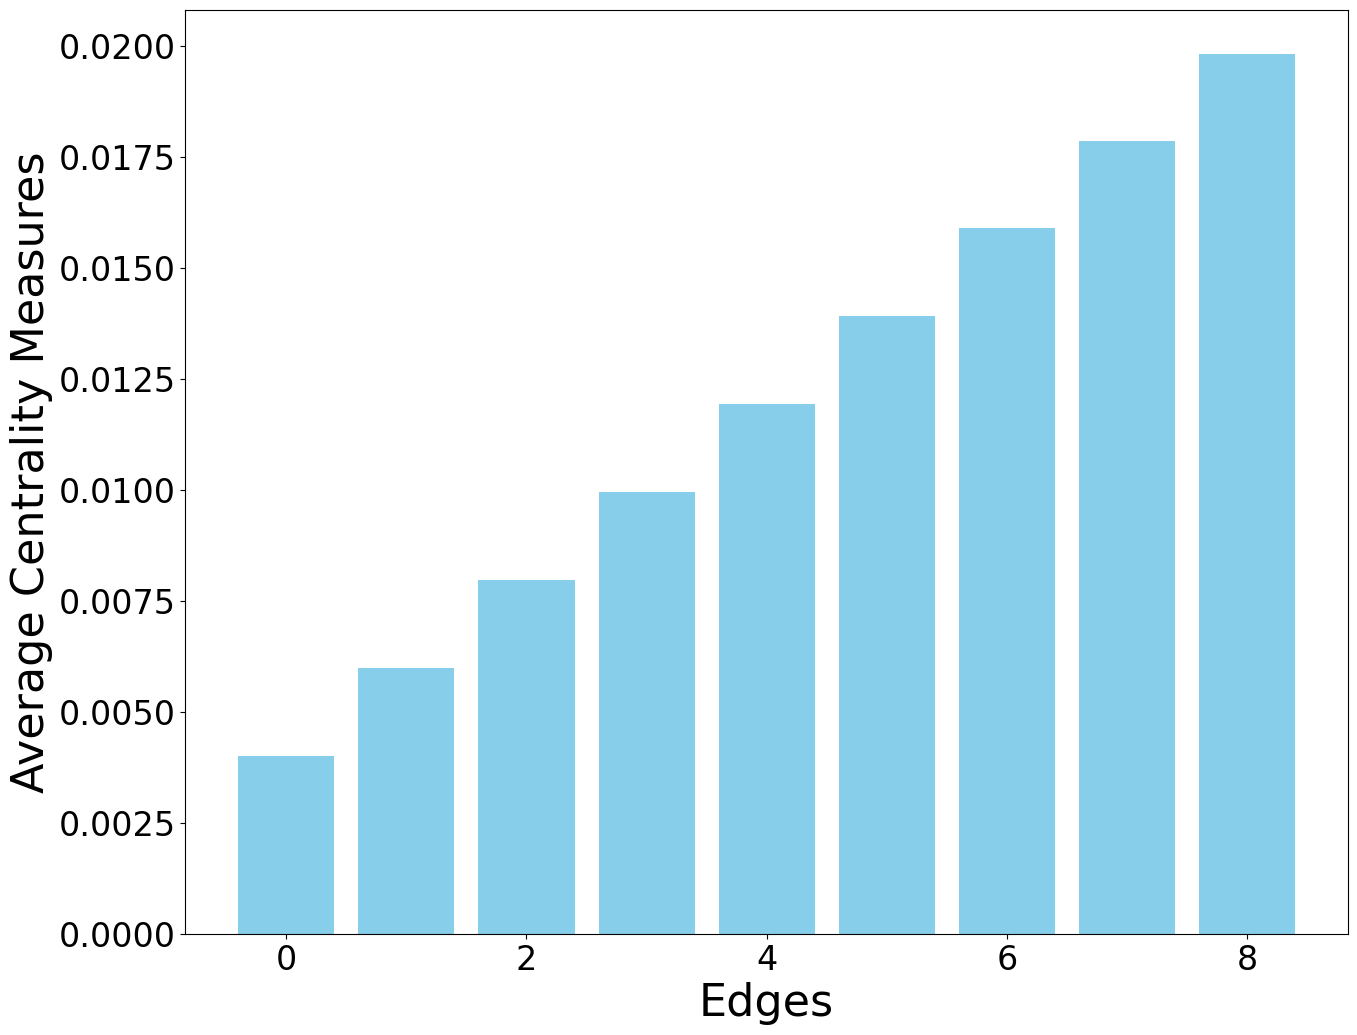

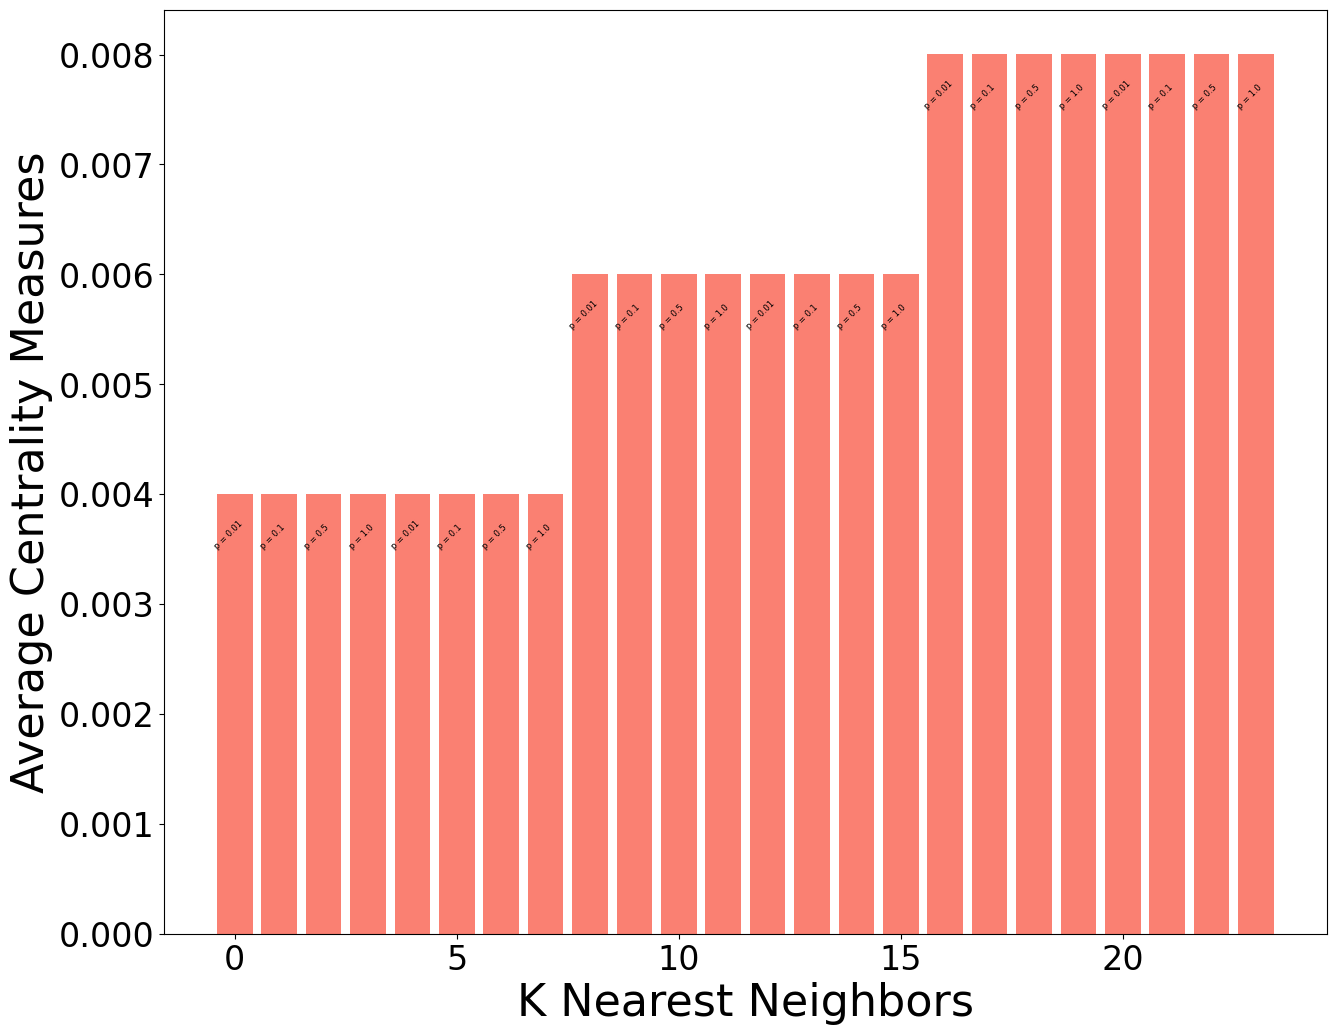

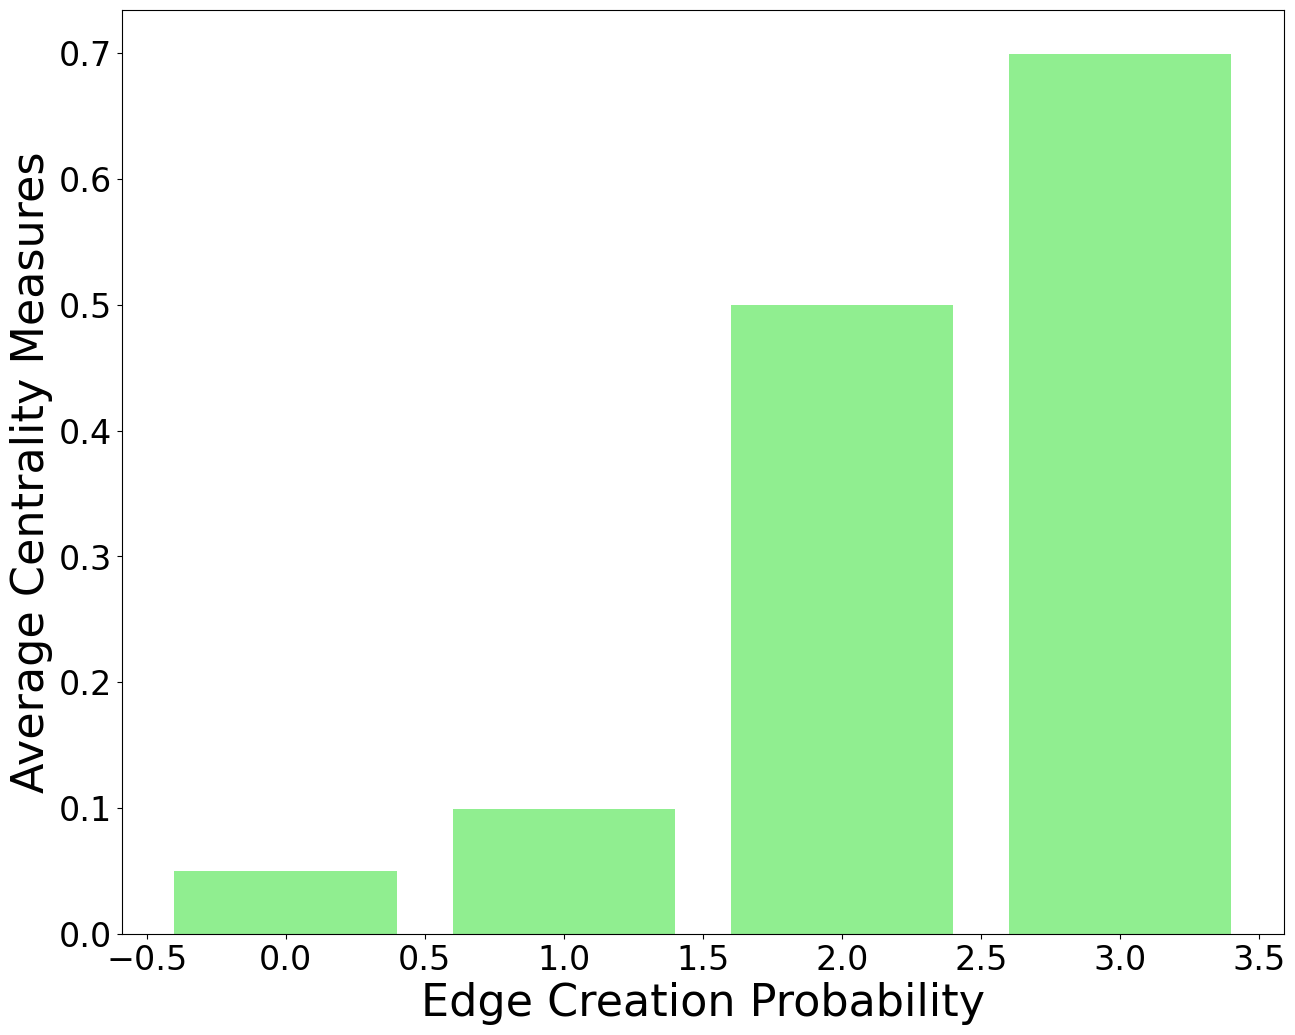

In [7]:
ba_avg_degree_centralities = []
ws_avg_degree_centralities = []
er_avg_degree_centralities = []

for edge in ba_num_of_edges:
    ba_graph = graph.barabasi_albert(num_of_edges=edge)
    avg_degree_centrality = sum(nx.degree_centrality(ba_graph).values()) / N
    ba_avg_degree_centralities.append(avg_degree_centrality)

for k in ws_k_nearest_neighbors:
    for p in ws_rewiring_probabilities:
        ws_graph = graph.watts_strogatz(k_nearest_neighbors=k, rewiring_probability=p)
        avg_degree_centrality = sum(nx.degree_centrality(ws_graph).values()) / N
        ws_avg_degree_centralities.append(avg_degree_centrality)

for p in er_creation_probabilities:
    er_graph = graph.erdos_renyi(edge_creation_probability=p)
    avg_degree_centrality = sum(nx.degree_centrality(er_graph).values()) / N
    er_avg_degree_centralities.append(avg_degree_centrality)

# Visualization for Barabási-Albert Average Degree Centrality
plt.figure(figsize=(15, 12))
plt.bar(range(len(ba_avg_degree_centralities)), ba_avg_degree_centralities, color='skyblue')
plt.xlabel('Edges', fontsize=32)
plt.xticks(fontsize=24) 
plt.ylabel('Average Centrality Measures', fontsize=32)
plt.yticks(fontsize=24) 
plt.savefig('../assets/ba_centrality.png')

# Visualization for Watts-Strogatz Average Degree Centrality
plt.figure(figsize=(15, 12))
bars = plt.bar(range(len(ws_avg_degree_centralities)), ws_avg_degree_centralities, color='salmon')
plt.xlabel('K Nearest Neighbors', fontsize=32)
plt.xticks(fontsize=24) 
plt.ylabel('Average Centrality Measures', fontsize=32)
plt.yticks(fontsize=24) 
for idx, bar in enumerate(bars):
    rewiring_prob = ws_rewiring_probabilities[idx % len(ws_rewiring_probabilities)]
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.15, 
             bar.get_height() - 0.0005, 
             f'p = {rewiring_prob}', 
             ha='center', 
             color='black',
             rotation=45,
             fontsize=6)
plt.savefig('../assets/ws_centrality.png')

# Visualization for Erdős–Rényi Average Degree Centrality
plt.figure(figsize=(15, 12))
plt.bar(range(len(er_avg_degree_centralities)), er_avg_degree_centralities, color='lightgreen')
plt.xlabel('Edge Creation Probability', fontsize=32)
plt.xticks(fontsize=24) 
plt.ylabel('Average Centrality Measures', fontsize=32)
plt.yticks(fontsize=24) 
plt.savefig('../assets/er_centrality.png')

In [ ]:
# Network topology
N = 1000
graph = Graph(num_of_nodes=N)
ba_graph = graph.barabasi_albert(num_of_edges=10)
ws_graph = graph.watts_strogatz(k_nearest_neighbors=6, rewiring_probability=0.5)
er_graph = graph.erdos_renyi(edge_creation_probability=0.5)

# Disease parameters
beta = 0.3
gamma = 0.1
fraction_infected = 0.1

In [ ]:
def simulate_spread(graph_type, network_abbrv):
    node_degrees = nx.degree_centrality(graph_type)
    top_3_highest = sorted(node_degrees.items(), key=lambda x: x[1], reverse=True)[:3]
    top_4_lowest = sorted(node_degrees.items(), key=lambda x: x[1])[:4]

    # Remove selected nodes and pick random 3 nodes
    selected_nodes = [node[0] for node in top_3_highest + top_4_lowest]
    remaining_nodes = [k for k, v in node_degrees.items() if k not in selected_nodes]
    random_3_keys = random.sample(remaining_nodes, 3)
    random_3 = [(key, node_degrees[key]) for key in random_3_keys]

    top_3_highest_degree_nodes = [node[0] for node in top_3_highest]
    top_4_lowest_degree_nodes = [node[0] for node in top_4_lowest]
    random_nodes = [node[0] for node in random_3]

    # Model selection
    model = ep.SIRModel(graph_type)

    # Model Configuration
    config = mc.Configuration()
    config.add_model_parameter('beta', beta)
    config.add_model_parameter('gamma', gamma)
    config.add_model_parameter("fraction_infected", fraction_infected)
    model.set_initial_status(config)

    # Simulation multiple execution
    infection_sets = [tuple(top_3_highest_degree_nodes), tuple(top_4_lowest_degree_nodes), tuple(random_nodes)]
    trends = multi_runs(model, execution_number=3, iteration_number=100, infection_sets=infection_sets, nprocesses=4)
    viz = DiffusionTrend(model, trends)
    viz.plot(f"../assets/{network_abbrv}_simulation_spread.png", percentile=90, descr=[fraction_infected, beta, gamma])

In [ ]:
simulate_spread(ba_graph, 'BA')
simulate_spread(ws_graph, 'WS')
simulate_spread(er_graph, 'ER')